In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import spotpy
from scipy import stats, signal, optimize
import hydroeval as he
import os.path
from scipy.stats import spearmanr
import datetime

In [2]:
# load primary data
data = xr.load_dataset('../data/hydro_krummh.nc').to_dataframe()
data.head()

,Prec_dissagg_1,Prec_dissagg_2,Prec_dissagg_3,Prec_dissagg_4,Prec_dissagg_5,Prec_dissagg_6,Prec_dissagg_7,Prec_dissagg_8,Prec_dissagg_9,Prec_dissagg_10,...,Prec_dissagg_77,Prec_dissagg_78,Prec_dissagg_79,Prec_dissagg_80,Prec,wl_Knock_Outer,wl_LW,wl_Knock_Inner,Knock_pump_obs,Q_Knock
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 01:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 02:00:00,0.0,0.0,0.0,0.491553,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,-1319.090942,NaN,NaN,NaN
2011-01-01 03:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1315.000000,NaN,NaN,NaN
2011-01-01 04:00:00,0.0,0.0,0.0,0.038447,0.0,0.240214,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1310.877563,NaN,NaN,NaN


# Plots time series of selected events

In [3]:
def plot_knock(t1,t2, plot_knock_level = True):
    fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = [11,7])
#    ax[0] = plt.subplot(311)  #, gridspec_kw={'height_ratios': [1, 2]}
    ax[0].plot(data['Prec'][t1:t2].cumsum(), label = 'Hourly precipitation\n(P) at Emden', linestyle = 'dotted')
#    ax[0].plot(data['Q_Knock'][t1:t2].resample('1d').sum().cumsum(), label = 'Daily runoff (E) at Knock', marker = 'o', linestyle = 'dotted')

    ax[0].set_ylabel('P and E\n[mm]')
    # set visibility of x-axis as False
    ax[0].tick_params('x', labelbottom=False)
    ax[0].set_title("Precipitation and Drainage", fontsize=13)
    ax[0].legend(bbox_to_anchor=(1, 0.2), loc="lower left", ncol=1, fontsize = 11)

#    ax[1] = plt.subplot(313, sharex = ax[0])
    
    if plot_knock_level:
        ax[1].plot(data['wl_Knock_Outer'][t1:t2]/1000, label = "$H_A$ [m]")
        ax[1].plot((data['wl_Knock_Inner'][t1:t2]/1000), label = "$H_I$ [m]")
        ax[1].fill_between(data['Knock_pump_obs'][t1:t2].index,(data['Knock_pump_obs'][t1:t2] / 100 - 2),-2, alpha = 0.2, label = "Used pump capacity\n(-2 = 0%)\n(-1 = 100%)")
        ax[1].axhline(min(data['wl_Knock_Inner'][data['Knock_pump_obs']>0]/1000), label = "$H_{min}$ [m]", linestyle = "dotted", alpha = 0.5, color = "orange")
    ax[1].plot((data['wl_LW'])[t1:t2]/1000, label = "$H_G$ [m] (LW)")
    ax[1].axhline(-0.9, label = "$H_Ü$ -0.9m", linestyle = "dotted", alpha = 0.5, color = "red")
    ax[1].axhline(-1.4, label = "$H_{P, winter}$ -1.4m", linestyle = "dotted", alpha = 0.5)

    ax[1].set_ylabel('Water level\n[mNN]')
    ax[1].set_ylim(-2,-0.5)
    ax[1].set_title("Water levels and pumping", fontsize=13)
    ax[1].legend(bbox_to_anchor=(1, -0.1), loc="lower left", ncol=1, fontsize = 11)
    ax[1].set_xlim([t1, t2])

    
#    ax[2] = plt.subplot(312, sharex = ax[0])
    ax[1].set_xlabel('Date')
        
    return(fig)

In [4]:
# select all days in which water level at Longewehr exceeded -950 mm
np.unique(data.index[data.wl_LW > -950].date)

array([datetime.date(2011, 9, 8), datetime.date(2011, 12, 6),
       datetime.date(2011, 12, 7), datetime.date(2011, 12, 8),
       datetime.date(2011, 12, 9), datetime.date(2011, 12, 10),
       datetime.date(2011, 12, 11), datetime.date(2011, 12, 12),
       datetime.date(2012, 1, 1), datetime.date(2012, 1, 2),
       datetime.date(2012, 1, 3), datetime.date(2012, 1, 4),
       datetime.date(2012, 1, 5), datetime.date(2012, 1, 6),
       datetime.date(2014, 5, 11), datetime.date(2014, 5, 12),
       datetime.date(2015, 11, 15), datetime.date(2015, 11, 16),
       datetime.date(2017, 3, 19), datetime.date(2017, 3, 20),
       datetime.date(2018, 1, 3), datetime.date(2018, 1, 4),
       datetime.date(2020, 2, 24), datetime.date(2020, 2, 25)],
      dtype=object)

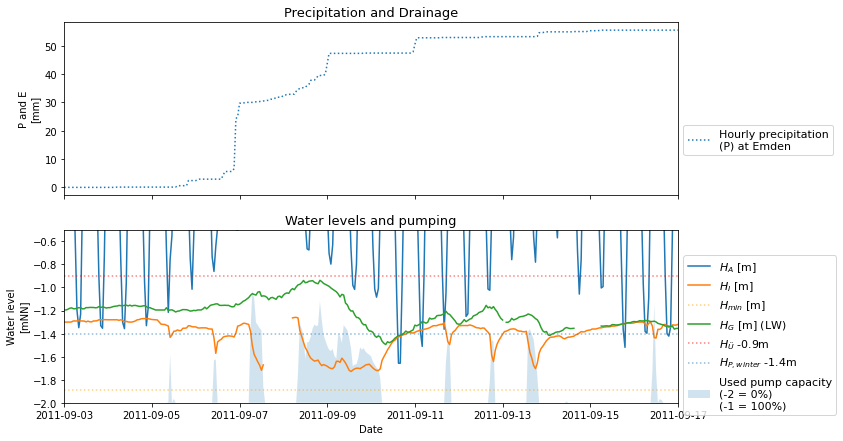

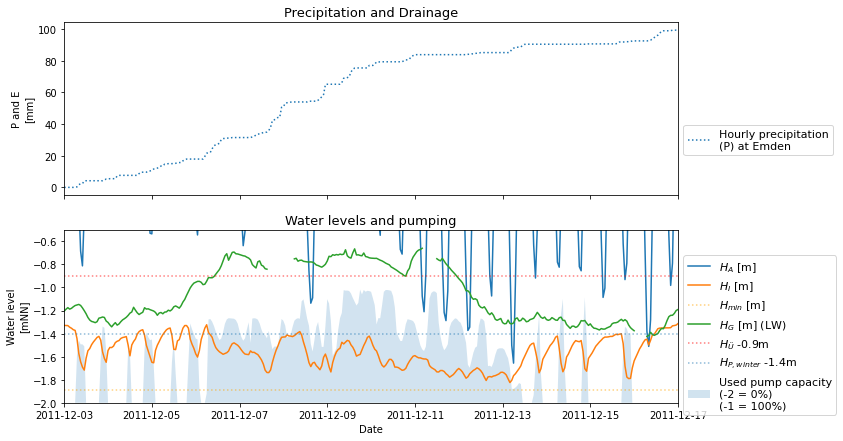

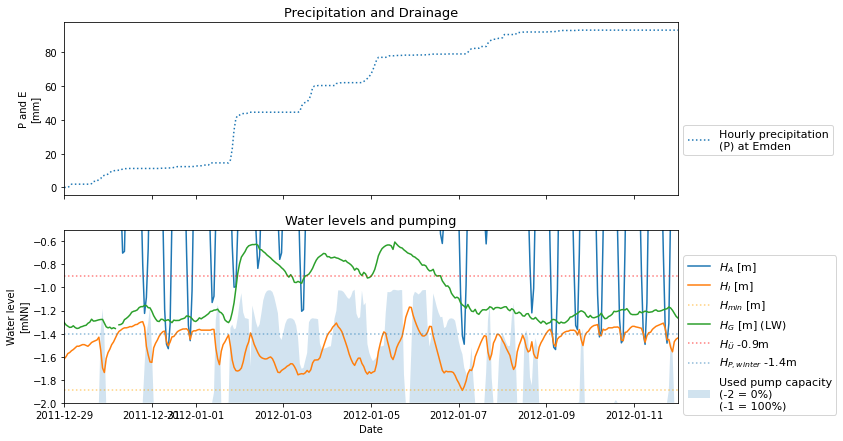

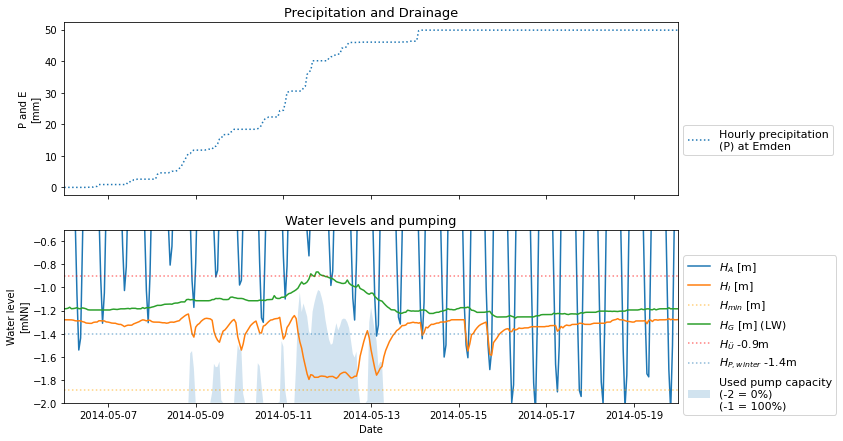

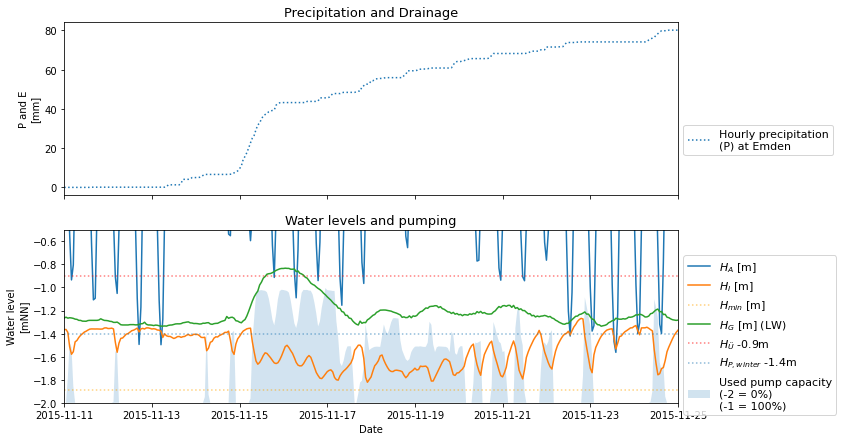

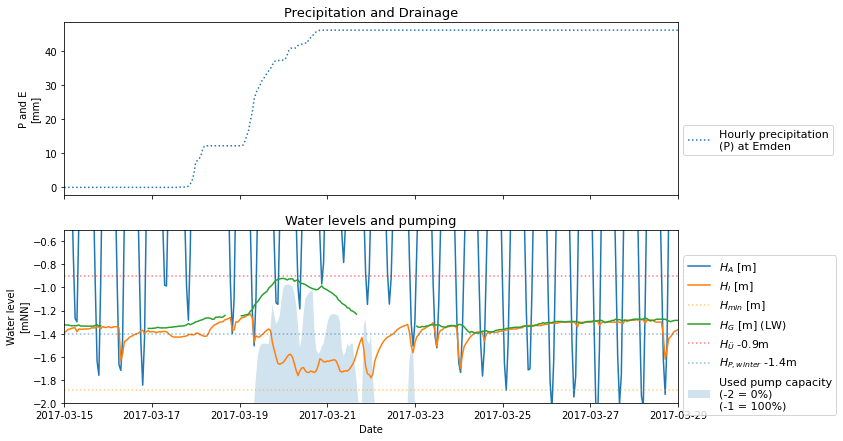

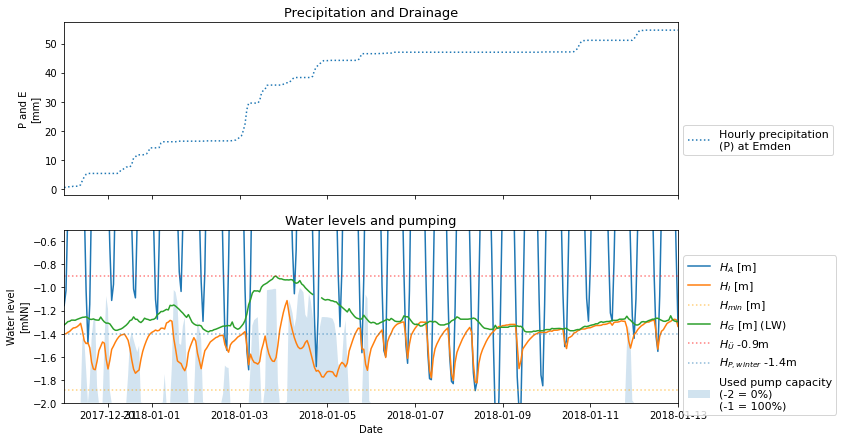

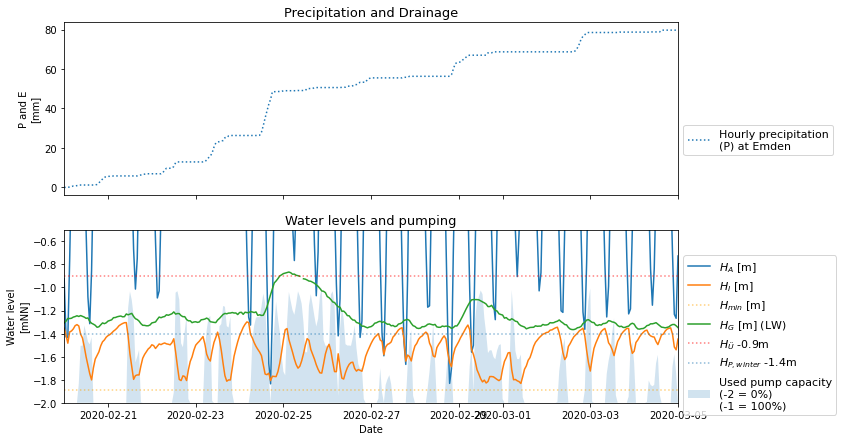

In [5]:
# manual definition of starting dates for these events and plotting
events = {
    "2011-09":datetime.date(2011, 9, 3),
    "2011-12":datetime.date(2011, 12, 3),
    "2012-01":datetime.date(2011, 12, 29),
    "2014-05":datetime.date(2014, 5, 6),
    "2015-11":datetime.date(2015, 11, 11),
    "2017-03":datetime.date(2017, 3, 15),
    "2018-01":datetime.date(2017, 12, 30),        
    "2020-02":datetime.date(2020, 2, 20)
}

for z in events:
    plot_knock(events[z],events[z]+datetime.timedelta(days=14))#.savefig("images/event_"+z+".png")